In [16]:
# !pip install facenet-pytorch

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
import os
from pathlib import Path


from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from albumentations.pytorch import ToTensorV2

In [46]:
img_dir = Path('/opt/ml/input/data/train/images')
seg_dir = Path('/opt/ml/input/data/train/images/seg')

face_crop_dir = Path('/opt/ml/input/data/train/images_face_crop')
seg_crop_dir = Path('/opt/ml/input/data/train/images_seg_crop')

if not os.path.isdir(face_crop_dir):
    os.mkdir(face_crop_dir)
    
if not os.path.isdir(seg_crop_dir):
    os.mkdir(seg_crop_dir)

csv_path = '/opt/ml/input/data/train/new_train.csv'
df = pd.read_csv(csv_path)
df

,id,mask,gender,age,totalLabel,customLabel,useMask,isCorrect,actualAge,ageModTen,errorM,errorG,errorA,error,isAug,path
0,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
1,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
2,000001,0,1,1,4,10,1,1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
3,000001,1,1,1,10,22,1,0,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
4,000001,2,1,1,16,34,0,-1,45,4,0,0,0,0,0,/opt/ml/input/data/train/images/000001_female_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18895,006959,0,0,0,0,1,1,1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18896,006959,1,0,0,6,13,1,0,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18897,006959,2,0,0,12,25,0,-1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...
18898,006959,0,0,0,0,1,1,1,19,1,0,0,0,0,0,/opt/ml/input/data/train/images/006959_male_As...


In [103]:
def faceCrop(img, faces, w_ratio, h_ratio, x, y):
    x1, y1, x2, y2 = faces[0][0]
    width = x2 - x1
    height = y2 - y1
    
    new_x = int(x1 - width * w_ratio / 2)
    new_y = int(y1 - height * h_ratio / 2)
    
    if(new_x < 0):
        w_ratio = x1 / width
        new_x = 0
    if(new_y < 0):
        h_ratio = y1 / height
        new_y = 0
    
    new_width = int(width * (1 + w_ratio))
    new_height = int(height * (1 + h_ratio))
    
    if(new_x + new_width > x):
        new_width = x - new_x
    if(new_y + new_height > y):
        new_height = y - new_y 
    
    transform = A.Compose([
                        A.Crop(new_x, new_y, new_x+new_width, new_y+new_height),
                        A.Resize(224, 224)
                        ])
    

    img = transform(image=np.array(img))['image']
    return img

train

In [104]:
li = df["mask"].to_list()
normal_idx = []
for i in range(len(li)):
    if li[i] == 2:
        normal_idx.append(i)

In [105]:
detector = MTCNN()

In [112]:
count = 0
people_n = int(len(df)/7)

for idx in range(1883, people_n):
    ori_normal_path = Path(df['path'].iloc[normal_idx[idx]])
    ori_normal_img = Image.open(ori_normal_path)
    ori_normal_face = detector.detect(ori_normal_img)
    img_fc_folder_dir = Path(str(ori_normal_path.parent).replace('images', 'images_face_crop'))
    img_sc_folder_dir = Path(str(ori_normal_path.parent).replace('images', 'images_seg_crop'))
    if not os.path.isdir(img_fc_folder_dir):
        os.mkdir(img_fc_folder_dir)
    
    if not os.path.isdir(img_sc_folder_dir):
        os.mkdir(img_sc_folder_dir)
    
    for j in range(7):
        ori_path = Path(df['path'].iloc[idx*7+j])
        seg_path = Path(str(df['path'].iloc[idx*7+j]).replace('images', 'images_seg'))
        
        ori_img = Image.open(ori_path)
        seg_img = Image.open(seg_path)
        
        ori_face = detector.detect(ori_img)
        if(ori_face[1][0] != None):
            face_crop_img = Image.fromarray(faceCrop(ori_img, ori_face, 0.3, 0.4, 384, 512))
            seg_crop_img = Image.fromarray(faceCrop(seg_img, ori_face, 0.3, 0.4, 384, 512))
        else:
            face_crop_img = Image.fromarray(faceCrop(ori_img, ori_normal_face, 0.3, 0.4, 384, 512))
            seg_crop_img = Image.fromarray(faceCrop(seg_img, ori_normal_face, 0.3, 0.4, 384, 512))

        
        face_crop_path = Path(str(df['path'].iloc[idx*7+j]).replace('images', 'images_face_crop'))
        seg_crop_path = Path(str(df['path'].iloc[idx*7+j]).replace('images', 'images_seg_crop'))

        face_crop_img.save(face_crop_path)
        seg_crop_img.save(seg_crop_path)
        
    if(idx % 100 == 0):
        print(idx)

1900
2000
2100
2200
2300
2400
2500
2600


## eval

In [ ]:
count = 0
# people_n = int(len(df)/7)
 
#     ori_normal_path = Path(df['path'].iloc[normal_idx[idx]].replace('images', 'images_resize'))
#     ori_normal_img = Image.open(ori_normal_path)
#     ori_normal_face = detector.detect(ori_normal_img)
#     for j in range(7):

transform = A.Compose([A.Crop(44, 44, 180, 180), A.Resize(224, 224)])
no_face = []
for idx in range(len(df)):

    ori_path = img_dir / Path(df['ImageID'].iloc[idx])
    seg_path = seg_dir / Path(df['ImageID'].iloc[idx])

    ori_img = Image.open(ori_path)
    seg_img = Image.open(seg_path)
    
    ori_face = detector.detect(ori_img)
    
    if(ori_face[1][0] != None):
        face_crop_img = Image.fromarray(faceCrop(ori_img, ori_face, 0.3, 0.4, 224, 224))
        seg_crop_img = Image.fromarray(faceCrop(seg_img, ori_face, 0.3, 0.4, 224, 224))
    else:
        face_crop_img = Image.fromarray(transform(image=np.array(ori_img))['image'])
        seg_crop_img = Image.fromarray(transform(image=np.array(seg_img))['image'])
        no_face.append(ori_path)


    face_crop_path = face_crop_dir / Path(df['ImageID'].iloc[idx])
    seg_crop_path = seg_crop_dir / Path(df['ImageID'].iloc[idx])

    face_crop_img.save(face_crop_path)
    seg_crop_img.save(seg_crop_path)

    if(idx % 1000 == 0):
        print(idx)

print(f'no faces -> {len(no_face)}')

In [103]:
iteri = iter(no_face)

In [139]:
path = next(iteri)


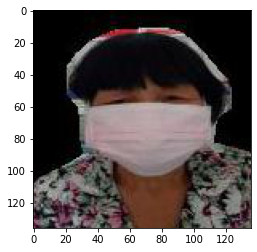

In [140]:
img = Image.open(path)
crop = Image.open(str(path).replace('images_resize', 'images_face_crop'))
seg = Image.open(str(path).replace('images_resize', 'images_seg_crop'))
# plt.imshow(img)
# plt.imshow(crop)
plt.imshow(seg)